In [1]:
import porespy.generators as generator
import matplotlib.pyplot as plt
import numpy as np
import statistics_plots as sp
import statistics_calc as sc
import phantom_generator as pg

# standart generator

(-0.5, 349.5, 349.5, -0.5)

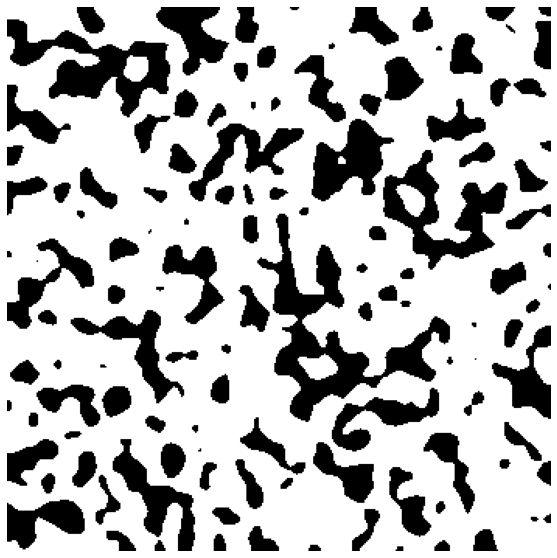

In [2]:
shape = [350, 350]
blobns = 2
porosity = 0.3
phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.axis("off")

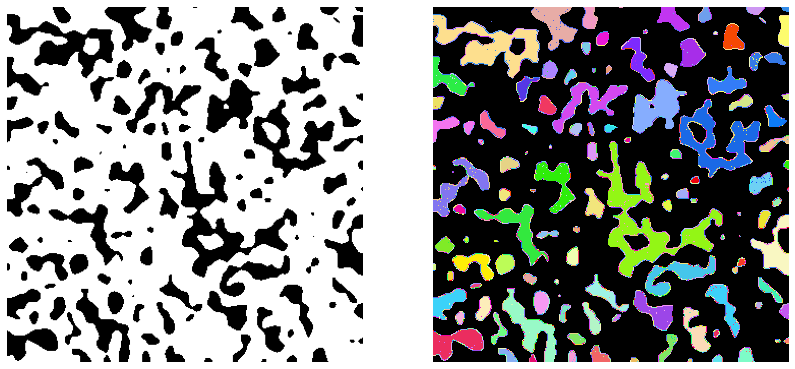

In [3]:
_ = sp.color_labeled_pores(phantom)

In [4]:
stats_volumes = sc.get_volume_stats(phantom)

In [5]:
get_radii = lambda volumes: np.sqrt(np.asarray(volumes) / np.pi)

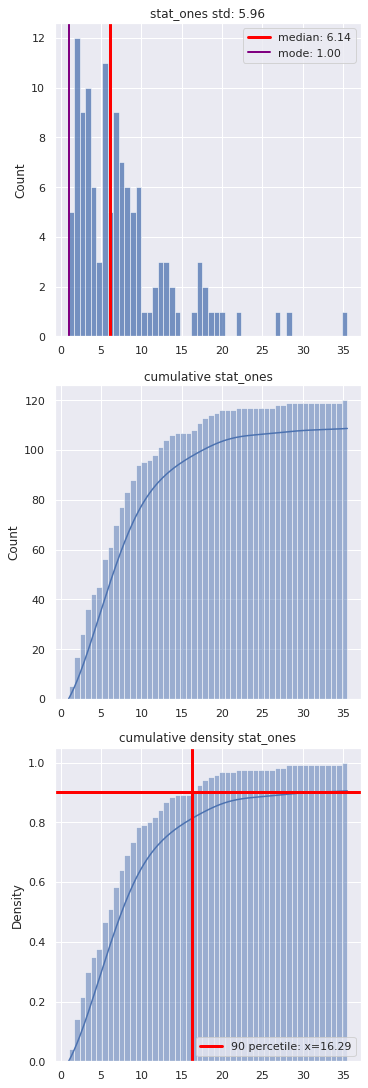

In [6]:
_ = sp.compare_stats(stats=[get_radii(stats_volumes)],
                     names_of_stats=["stat_ones", "stat_zeros"],
                     num_bins=50,
                     add_characteristics="median")

# own generator

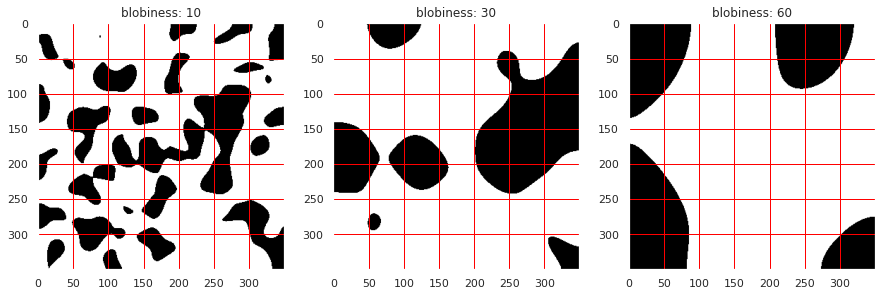

In [7]:
blobnsess = [10, 30, 60]
porosity = 0.3

phantoms = [pg.gen_phantom(shape, porosity=porosity, blobiness=b) for b in blobnsess]

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ax, blobns, phantom in zip(axes, blobnsess, phantoms):
    ax.imshow(phantom, cmap='gray')
    ax.set_title(f"blobiness: {blobns}")
    ax.grid(color='red')

Text(0.5, 0.98, 'statistics for PORE-volumes')

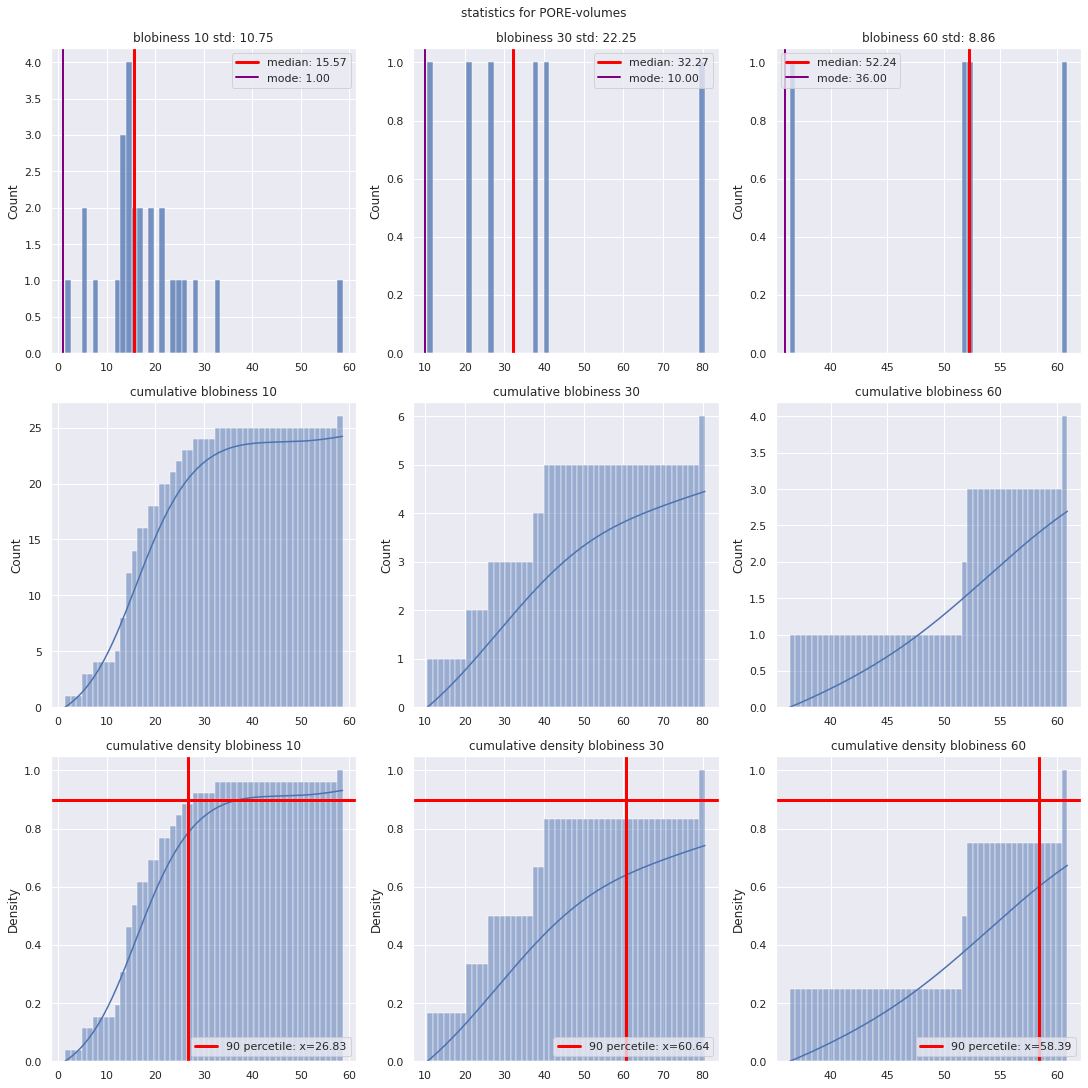

In [8]:
stats_radii = [get_radii(sc.get_volume_stats(phantom)) for phantom in phantoms]
fig = sp.compare_stats(stats=stats_radii,
                       names_of_stats=[f"blobiness {b}" for b in blobnsess],
                       add_characteristics="median",
                       num_bins=50)
fig.suptitle(f"statistics for PORE-volumes")


# Trial to find dependecies

In [9]:
from scipy.stats import mode
import seaborn as sns

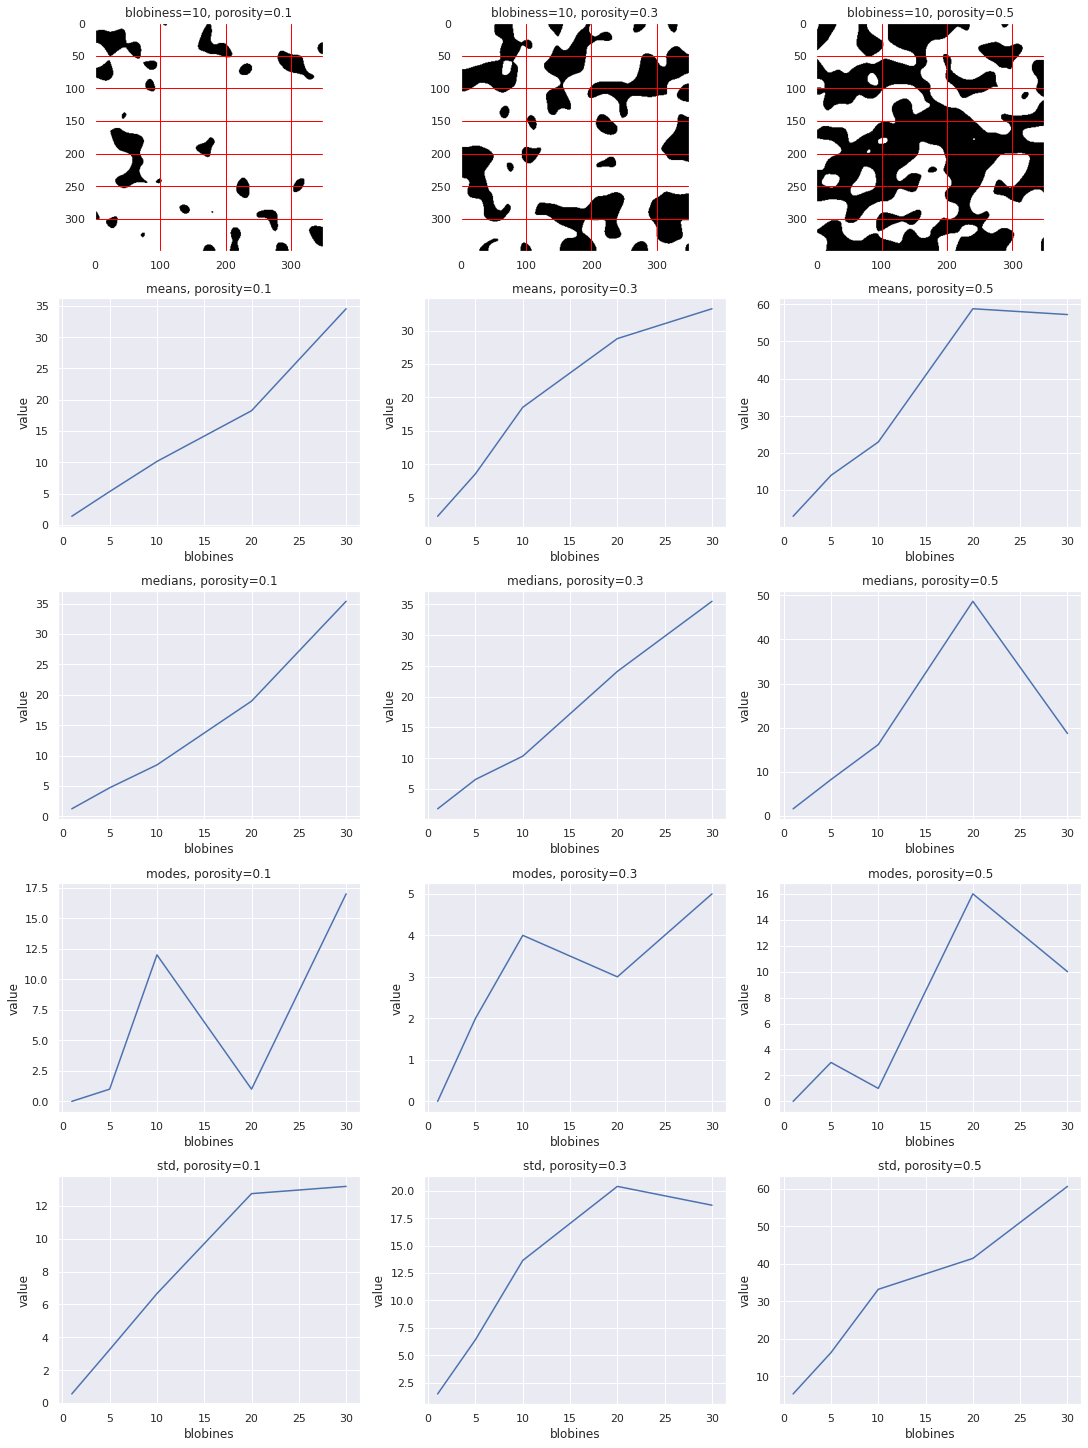

In [10]:
blobnses = [1, 5, 10, 20, 30]
porosities = [0.1, 0.3, 0.5]
axis = "Both"

fig, axes = plt.subplots(ncols=len(porosities), nrows=5, figsize=(15, 20), constrained_layout=True)
for ax in axes.flatten()[3:]:
    ax.set(xlabel='blobines', ylabel='value')
axes = np.transpose(axes)

for porosity, axes_col in zip(porosities, axes):
    own_phantoms = [pg.gen_phantom(shape, porosity=porosity, blobiness=b) for b in blobnses]
    middle_index = len(blobnses)//2
    axes_col[0].imshow(own_phantoms[middle_index], cmap="gray")
    axes_col[0].set_title(f"blobiness={blobnses[middle_index]}, porosity={porosity}")
    axes_col[0].grid(color='red')

    stats_radii = [get_radii(sc.get_volume_stats(phantom)) for phantom in own_phantoms]

    means, modes, st_devs, medians= [], [], [], []
    for stat_volumes in stats_radii:
        means.append(np.mean(stat_volumes))
        medians.append(np.median(stat_volumes))
        modes.append(int(mode(stat_volumes)[0]))
        st_devs.append(np.std(stat_volumes))

    sns.lineplot(x=blobnses, y=means, markers=True, ax=axes_col[1]).set_title(f"means, porosity={porosity}")
    sns.lineplot(x=blobnses, y=medians, markers=True, ax=axes_col[2]).set_title(f"medians, porosity={porosity}")
    sns.lineplot(x=blobnses, y=modes, markers=True, ax=axes_col[3]).set_title(f"modes, porosity={porosity}")
    sns.lineplot(x=blobnses, y=st_devs, markers=True, ax=axes_col[4]).set_title(f"std, porosity={porosity}")

# Regression

In [11]:
train_dataframe = sc.generate_train_data(sc.get_volume_stats, volume_to_diameters=True, shape=shape)

In [12]:
train_dataframe

,porosity,blobiness,hist_characteristical_number
0,0.1,1.0,1.261566
1,0.1,5.0,5.470021
2,0.1,10.0,9.812411
3,0.1,20.0,22.113454
4,0.1,30.0,27.765924
...,...,...,...
145,0.5,1.0,1.692569
146,0.5,5.0,7.673808
147,0.5,10.0,20.867389
148,0.5,20.0,52.489214


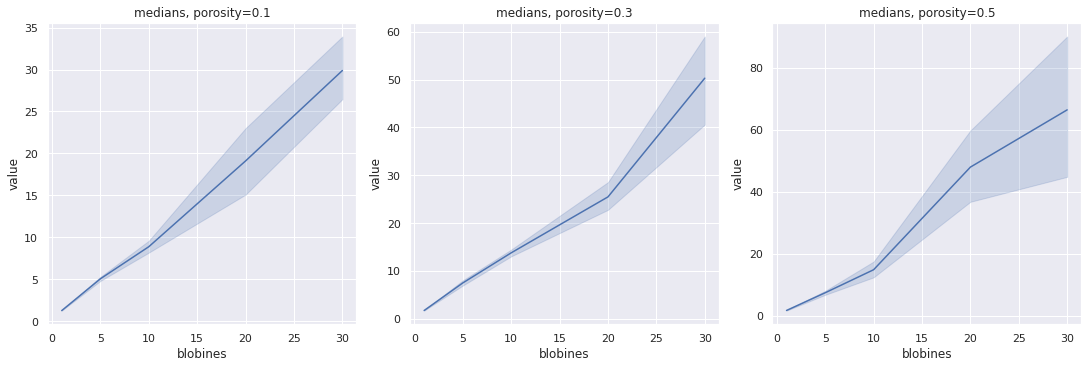

In [13]:
fig, axes = plt.subplots(ncols=len(porosities), figsize=(15, 5), constrained_layout=True)
porosities = np.unique(train_dataframe["porosity"])
for ax, p in zip(axes, porosities):
    ax.set(xlabel='blobines', ylabel='value')
    sns.lineplot(data=train_dataframe[train_dataframe["porosity"]==p], \
                 x="blobiness", y="hist_characteristical_number", ax=ax).set_title(f"medians, porosity={p}")

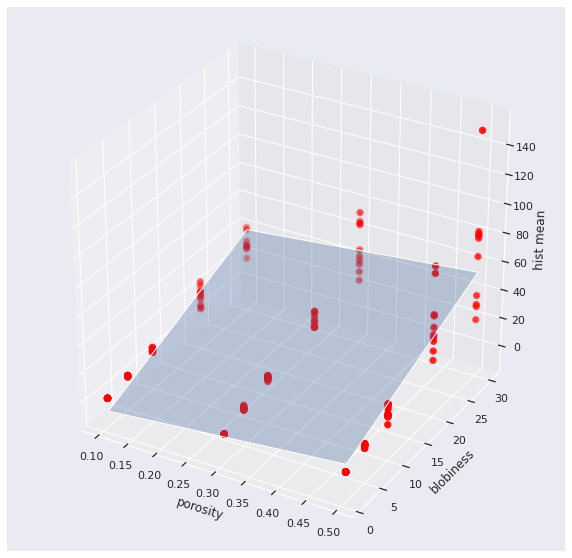

In [14]:
_ = sp.plot_data_scatter(train_dataframe, True)

# Test phantoms

In [15]:
coefs = sc.get_regression_coefs_by_plane(train_dataframe)

(-0.5, 349.5, 349.5, -0.5)

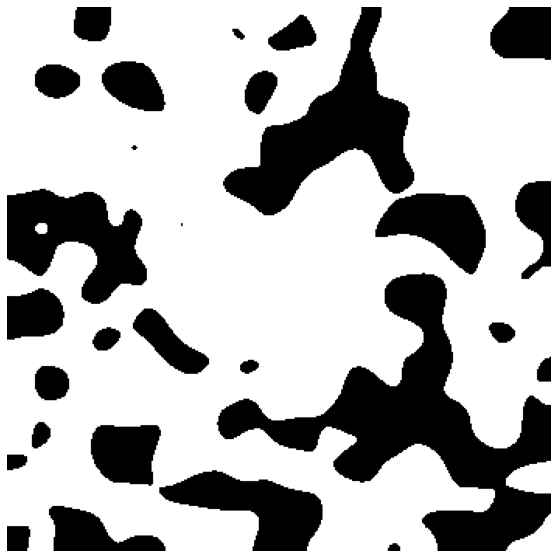

In [16]:
blobnsess = 10
porosity = 0.3

phantom = pg.gen_phantom(shape, porosity=porosity, blobiness=blobnsess)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.axis("off")

In [17]:
sc.find_blobiness(bin_image=phantom,
                  porosity=porosity,
                  stat_counting_function=sc.get_volume_stats,
                  volume_to_diameters=True,
                  regression_coefs=coefs)

8.364182945096108

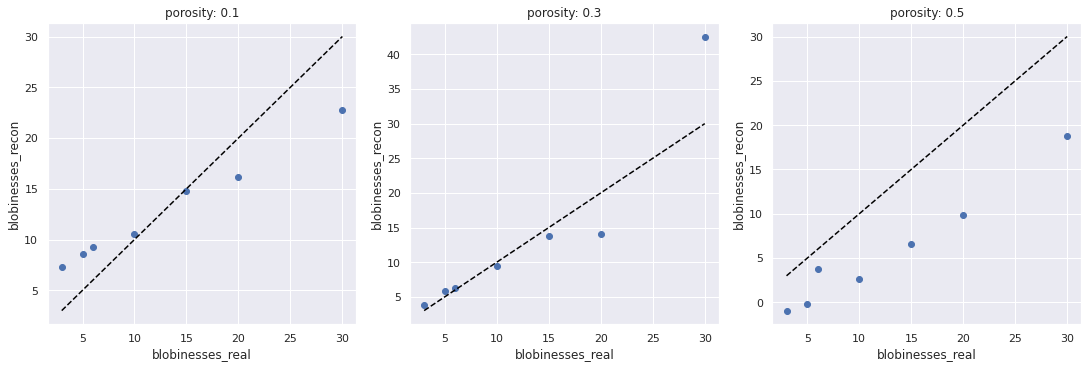

In [18]:
porosities = [0.1, 0.3, 0.5]
blobinesses_real = [3, 5, 6, 10, 15, 20, 30]

fig, axes = plt.subplots(ncols=len(porosities), figsize=(15, 5), constrained_layout=True)

for porosity, ax in zip(porosities, axes):
    blobinesses_recon = []
    for blobns_real in blobinesses_real:
        phantom = pg.gen_phantom(shape, porosity=porosity, blobiness=blobns_real)
        blobinesses_recon.append(sc.find_blobiness(bin_image=phantom,
                                                   porosity=porosity,
                                                   stat_counting_function=sc.get_volume_stats,
                                                   volume_to_diameters=True,
                                                   regression_coefs=coefs))
    
    ax.scatter(x=blobinesses_real, y=blobinesses_recon)
    ax.plot([np.min(blobinesses_real), np.max(blobinesses_real)], 
            [np.min(blobinesses_real), np.max(blobinesses_real)],
            linestyle="dashed",
            color="black")
    ax.set_xlabel("blobinesses_real")
    ax.set_ylabel("blobinesses_recon")
    ax.set_title(f"porosity: {porosity}")

# Test real

In [19]:
import h5py
from skimage.filters import threshold_otsu

In [20]:
h5f = h5py.File('sample.h5','r')
img2d = h5f['layer1'][:]
h5f.close()

In [21]:
thresh = threshold_otsu(img2d)
img2d_bin = img2d > thresh

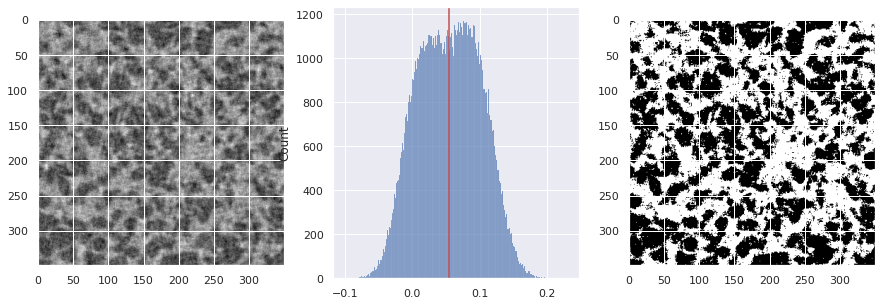

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(img2d, cmap='gray')

sns.histplot(img2d.ravel(), bins=256, ax=axes[1], kde=False)
axes[1].axvline(thresh, color='r')
axes[2].imshow(img2d_bin, cmap='gray')


In [23]:
porosity_img2d = np.sum(img2d_bin) / img2d_bin.size
porosity_img2d


0.5073632653061224

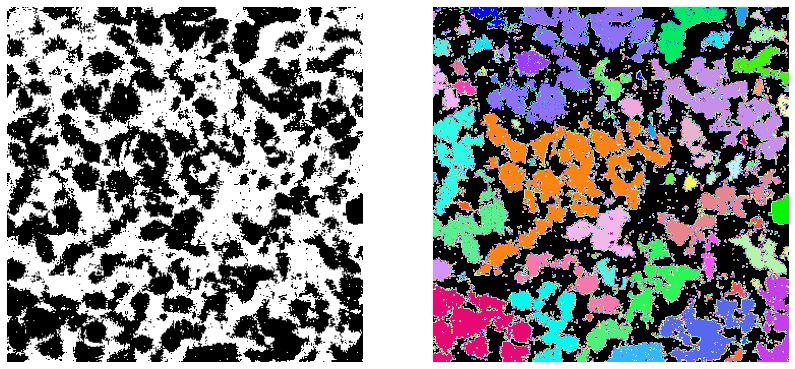

In [24]:
_ = sp.color_labeled_pores(img2d_bin)

In [25]:
stats_volumes = sc.get_volume_stats(img2d_bin)
stats_volumes = np.asarray(stats_volumes)

In [26]:
stats_volumes = stats_volumes[stats_volumes>200]

In [27]:
stats_volumes

array([ 506, 6407, 1657,  373,  308,  237,  233,  802,  602, 4600,  524,
        506,  249,  349, 2396, 8833,  732,  254, 2176, 2311,  418, 1590,
        365,  948, 2262, 1615,  323,  414, 1651, 2134, 4388, 3077,  903,
        866])

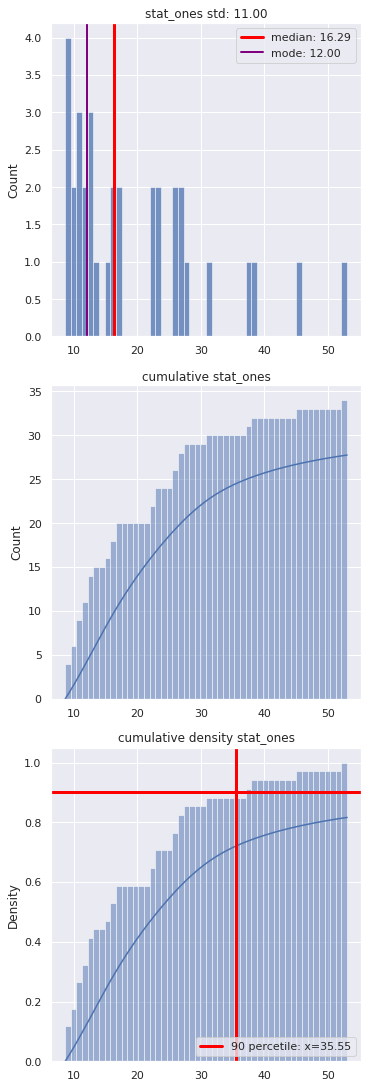

In [28]:

_ = sp.compare_stats(stats=[get_radii(stats_volumes)],
                     names_of_stats=["stat_ones", "stat_zeros"],
                     num_bins=50,
                     add_characteristics="median")

In [29]:
blobnsess_calculated = sc.find_blobiness(bin_image=img2d_bin,
                                         porosity=porosity_img2d,
                                         stat_counting_function=sc.get_volume_stats,
                                         volume_to_diameters=True,
                                         regression_coefs=coefs)
blobnsess_calculated

-2.996797547823268

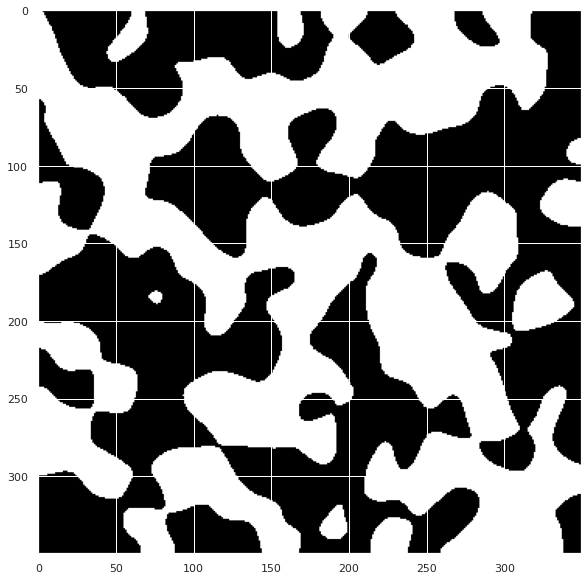

In [30]:

phantom = pg.gen_phantom(shape, porosity=porosity_img2d, blobiness=10)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')